In [122]:
import os 
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils.tools import diffangle

# lbs tools package is avaliable at https://github.com/labstructbioinf/lbs-tools
sys.path.append('/home/nfs/sdunin/scr/lbs-tools/')
from lbs.sequences import mmseqs2

In [123]:
data_dir = './data/'

# referece Crick angles
crangles = {'a':19.5,'b':122.35,'c':-134.78,'d': -31.92,'e':70.92 ,'f':173.78,'g':-83.35}

In [124]:
def calc_balance(class_name, norm=True):
    
    BINS = list(np.linspace(-52, 52, 26))
    
    tmp = pd.cut(data_df[data_df['class']==class_name].rot_mean, bins=BINS, labels=False, retbins=False)#.value_counts().sort_index()
    res_vec = np.zeros(len(BINS))
    
    for g_idx, g in tmp.groupby(tmp):
        res_vec[g_idx] = len(g)

    if norm:
        res_vec = res_vec / res_vec.sum()
        
    return res_vec

In [125]:

def check_crick(row, MAXROT=55):
    return (np.abs(diffangle(row.n_crick_mut[:2].mean(), crangles['a'])) <= MAXROT) and \
           (np.abs(diffangle(row.c_crick_mut[:2].mean(), crangles['a'])) <= MAXROT) 

def plot(df, BINS=26):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=100)
    df['rot_mean'].plot.hist(bins=BINS, ax=ax)
    ax.axvline(x=-52, c='r')
    ax.axvline(x=52, c='r')

# Read & validate data

In [126]:
data_df = pd.read_pickle(os.path.join(data_dir, 'af2.p')) 
# calculate the relative rotation (i.e., the per-layer difference between N and C helices rotation) 
data_df['rot'] = diffangle(data_df.n_crick_mut, data_df.c_crick_mut)
data_df['rot_mean'] = data_df['rot'].apply(np.mean)
data_df['rot_std'] = data_df['rot'].apply(np.std)
data_df['sequence'] = data_df['n_seq'] + data_df['c_seq'] # for mmseqs2 clustering

len(data_df)

5314

In [127]:
data_df = data_df[data_df.apply(check_crick, axis=1)]
len(data_df)

5124

<AxesSubplot: >

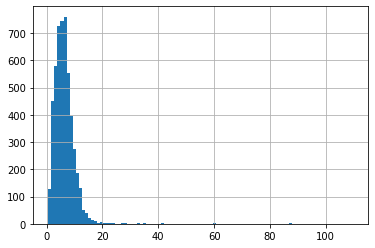

In [128]:
data_df.rot_std.hist(bins=100)

In [129]:
data_df = data_df[data_df.rot_std <= 14]
data_df = data_df[data_df.rot_mean.abs() <= 52]
len(data_df)

4972

In [130]:
#plot(data_df)

# Generate validation set
`random sampling`

In [151]:
MAX_VAL_FRAC = 0.15 # fraction of val in the whole set (model #1)
#MAX_VAL_FRAC = 0.001 # fraction of val in the whole set (model #2)
data_df['class'] = 'train'
val_samples = int(len(data_df)*MAX_VAL_FRAC)
val_idx = np.random.choice(data_df.index, size = val_samples, replace=False)
data_df.loc[val_idx, 'class'] = 'val'


In [152]:
data_df['class'].value_counts()

train    4227
val       745
Name: class, dtype: int64

# Check and save

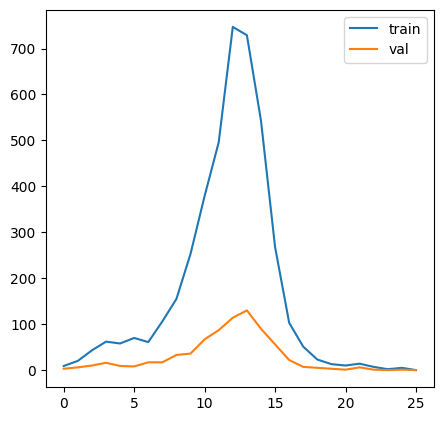

In [153]:
train_dist = calc_balance('train', norm=False)
val_dist = calc_balance('val', norm=False)

fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=100)

ax.plot(train_dist, label='train')
ax.plot(val_dist, label='val')
ax.legend()

In [154]:
data_df['class'].value_counts()

train    4227
val       745
Name: class, dtype: int64

In [155]:
# no class balance, just the train-val split
data_df.to_pickle(os.path.join(data_dir, 'af2_clean_model_1.p'))

# Generate validation set
`keep the same distribution to the train set`

In [147]:
MAX_VAL_FRAC = 0.3 # fraction of val in the whole set
MAX_IDENT = 0.3 # max seq ident between train and validation 


In [10]:
c = mmseqs2.MMSeqsClusterer()
data_df = c.cluster(data_df, min_identity=MAX_IDENT, coverage=0.7)


createdb /tmp/esn0f2fl tmp/7054459524698818462/input --max-seq-len 65535 --dont-split-seq-by-len 1 --dbtype 0 --dont-shuffle 1 --id-offset 0 --compressed 0 -v 3 

Converting sequences
[
Time for merging files: 0h 0m 0s 8ms
Time for merging files: 0h 0m 0s 6ms
Time for merging files: 0h 0m 0s 0ms
Time for processing: 0h 0m 0s 33ms
kmermatcher tmp/7054459524698818462/input tmp/7054459524698818462/clu_tmp/12475928386733316123/linclust/797861150045913196/pref --sub-mat blosum62.out --alph-size 13 --min-seq-id 0.3 --kmer-per-seq 21 --adjust-kmer-len 0 --mask 0 --mask-lower-case 0 --cov-mode 0 -k 0 -c 0.7 --max-seq-len 65535 --hash-shift 5 --split-memory-limit 0 --include-only-extendable 0 --skip-n-repeat-kmer 0 --threads 20 --compressed 0 -v 3 

Database size: 4298 type: Aminoacid
Reduced amino acid alphabet: (A S T) (C) (D B N) (E Q Z) (F Y) (G) (H) (I V) (K R) (L J M) (P) (W) (X) 

Estimated memory consumption 1 MB
Generate k-mers list for 1 split
[========================================

[=================================================================] 3.17K 0s 0ms
Index statistics
Entries:          12674
DB size:          488 MB
Avg k-mer size:   0.000198
Top 10 k-mers
    EIDAFN	18
    EFEAFN	17
    EIQAFN	16
    EIRAFN	13
    EIQGFN	11
    ELQGFN	8
    EIRGFN	8
    EFESFN	8
    EIQSFN	7
    EIEGFN	6
Time for index table init: 0h 0m 0s 468ms
k-mer similarity threshold: 154
	k-mers per position = 0.254923, k-mer match probability: 0.000000
k-mer match probability: 0.000000

Starting prefiltering scores calculation (step 1 of 1)
Query db start  1 to 3174
Target db start  1 to 3174
[================================================================] 3.17K 0s 1ms
=
0.234053 k-mers per position
5 DB matches per sequence
0 overflows
2 sequences passed prefiltering per query sequence
1 median result list length
0 sequences with 0 size result lists

Time for prefiltering scores calculation: 0h 0m 0s 5ms
Time for merging files: 0h 0m 0s 6ms
Time for processing: 0h 0m 0s 723ms

[=================================================================] 1.79K 0s 2ms
Index statistics
Entries:          30377
DB size:          488 MB
Avg k-mer size:   0.000475
Top 10 k-mers
    AEGLAL	21
    AEGLSL	17
    AEGLAM	8
    AEALAL	7
    AEGMAL	7
    ELEAFN	7
    AEGLAV	7
    ELAAFN	6
    ELDAFN	6
    AEGVAV	6
Time for index table init: 0h 0m 0s 490ms
k-mer similarity threshold: 118
Starting prefiltering scores calculation (step 1 of 1)
Query db start  1 to 1789
Target db start  1 to 1789
[=================================================================] 1.79K 0s 14ms

39.135013 k-mers per position
39 DB matches per sequence
0 overflows
12 sequences passed prefiltering per query sequence
13 median result list length
0 sequences with 0 size result lists

Time for prefiltering scores calculation: 0h 0m 0s 19ms
Time for merging files: 0h 0m 0s 6ms
Time for processing: 0h 0m 0s 752ms
align tmp/7054459524698818462/clu_tmp/12475928386733316123/input_step2 tmp/7054459524698818462/clu

In [11]:
len(data_df.clust_id.unique())

1084

In [12]:
final_dist = 1

while final_dist > 0.02:

    data_df['class'] = 'train'
    clusters = data_df.clust_id.unique().tolist()
    prev_dist = 1
    moved=0

    while True:
        # biggest first
        # probability_distribution = 
        cl_move = np.random.choice(clusters)

        data_df.loc[
            data_df.clust_id == cl_move,
            'class'
        ] = 'val'

        train_dist = list(calc_balance('train'))
        val_dist = list(calc_balance('val'))
        
        RANG=6
        train_dist = train_dist[:RANG] + train_dist[-RANG:]
        val_dist = val_dist[:RANG] + val_dist[-RANG:]
        
        dist = np.linalg.norm(np.asarray(train_dist)-np.asarray(val_dist))

        if dist < prev_dist: #or np.random.rand() >= 0.95:
            # accept cluster move
            clusters.remove(cl_move)
            moved+=1
        else:
            # revert cluster move
            data_df.loc[
                data_df.clust_id == cl_move,
                'class'
            ] = 'train'        

        val_frac = (data_df['class'] == 'val').sum() / len(data_df)

        if val_frac >= MAX_VAL_FRAC: 
            final_dist = dist
            print(final_dist.round(2), moved)
            break



0.01 342


# Class balance
`may cause data loss`

In [114]:
def balance(df):
    df['freq'] = 1./df.groupby('rot_mean_bin')['rot_mean_bin'].transform('count')
    idx = [df.sample(1, weights = df.freq).iloc[0].name for _ in range(len(df))]
    return idx

In [115]:
BINS = list(np.linspace(-52, 52, 26))

data_df['rot_mean_bin'] = pd.cut(data_df.rot_mean, bins=BINS, labels=False)

data_df_val = data_df[data_df['class'] == 'val'].copy()
data_df_train = data_df[data_df['class'] == 'train'].copy()


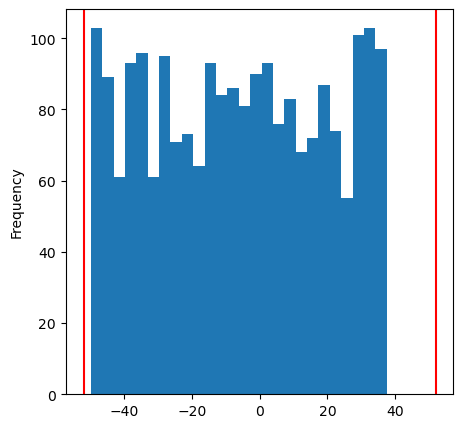

In [116]:
idx_train = balance(data_df_train)
plot(data_df_train.loc[idx_train])

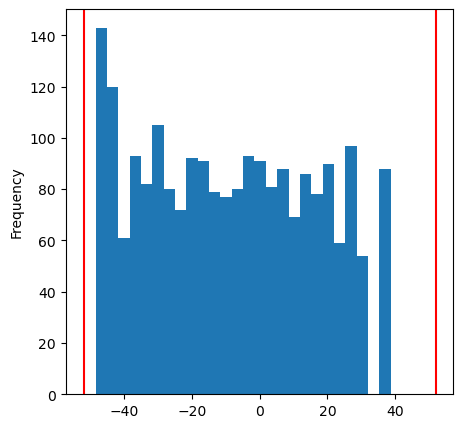

In [117]:
idx_val = balance(data_df_val)
plot(data_df_val.loc[idx_val])

In [118]:
assert set(data_df_val.loc[idx_val].sequence) & set(data_df_train.loc[idx_train].sequence) == set()

In [119]:
# split with class balance
pd.concat([
    data_df_val.loc[idx_val], 
    data_df_train.loc[idx_train]
]).to_pickle(os.path.join(data_dir, 'af2_balance_clean.p'))